<a href="https://colab.research.google.com/github/aravindchakravarti/Deep_Learning_EVA_4/blob/master/S10_Cifar_Resnet/S10_Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up Google Drive and Libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload 2

In [0]:
# All the supporting python files are saved in GDrive
import sys
sys.path.append('./gdrive/My Drive/EVA_Library/')

In [5]:
# Print library info. Not completely written yet
from TestLibraryVersion import PrintLibraryInfo
PrintLibraryInfo()

The current version of the Library is 1.1


In [6]:
from cifarImageLoader.DatasetLoader import getCifar10Data, cifar10WithAlbumentations
from cnnModels.CNNModel import displayModelSummary, plainArch, ResNet18
from modelTraining.modelTraining import setupOptimizer, runTheModel, modelTrainTestHistory
from utils.utils import isCudaAvailable
from modelTraining.lrFinder import LRFinder
from gradCAM.visual import GradCAMView, plot_gradcam
from utils.misClassfiedImages import misClassfied, displayMisClassfiedImages
from cifarImageLoader.displayImages import displayDataSetSampleImages
!pip install torchsummary
#!pip install -U git+https://github.com/albu/albumentations


  pip install torch-lr-finder -v --global-option="amp"


# Set the Arguments for project and Setup Train/Test Dataset 

In [0]:
# Arguments for the functions
class Args:
  # ---- Data Loader Arguments -----
  train_batch_size = 512
  test_batch_size = 512
  num_workers = 4
  dataset_mean = [0.4914, 0.4822, 0.4465]
  dataset_std = [0.2023, 0.1994, 0.2010]
  classes = ['plane', 'car', 'bird', 'cat',
             'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class modelExtraSettings:
  '''Additional setting which are useful when debugging model '''
  RunLRFinder = False
  display_summary = False
  

In [8]:
# Get the Cifar-10 dataset and apply Ablumentation image augmentation techniques
train_loader, test_loader = cifar10WithAlbumentations(
                            batch_size = Args.train_batch_size, 
                            number_of_workers = Args.num_workers,
                            prob_transform = Args.num_workers  
                            )

Now downloading and allocating dataset
Cuda Available? cuda


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Now allocating Dataloaders


In [9]:
# Display the sample images. Images will be saved in current directory
displayDataSetSampleImages(train_loader, Args.classes,
                           Args.dataset_mean, Args.dataset_std, 
                           num_of_images = 20)

torch.Size([512, 32, 32, 3])


<Figure size 720x720 with 0 Axes>

# Train the Model

In [10]:
device = isCudaAvailable()
print (device)

cuda


In [0]:
model = ResNet18().to(device)

In [0]:
if modelExtraSettings.display_summary == True:
  displayModelSummary(model)

In [0]:
import torch.nn as nn
from torch.optim import SGD, Adam

if modelExtraSettings.RunLRFinder == True:
  criterion = nn.NLLLoss()
  optimizer = SGD(model.parameters(), lr=0.00001)
  lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
  lr_finder.range_test(train_loader, end_lr=10, num_iter=1000, step_mode="exp")


0.023878112829131756


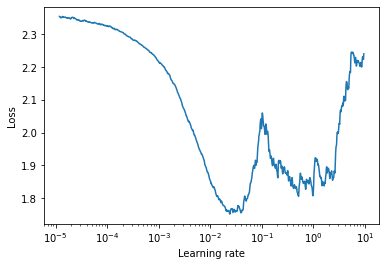

In [0]:
if modelExtraSettings.RunLRFinder == True:
  lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
  print (lr)
  lr_finder.plot()

In [0]:
optimizer, scheduler = setupOptimizer(model, device, optimzer_select='NLLLoss', lr = 0.025)

In [0]:
train_losses, train_acc, test_losses, test_acc = runTheModel(model=model, 
                                                            device=device, 
                                                            optimizer=optimizer, 
                                                            train_loader=train_loader, 
                                                            test_loader=test_loader, 
                                                            scheduler=scheduler,
                                                            epochs = 50)


In [22]:
# Final Test Accuracy
test_acc[-1]

88.2

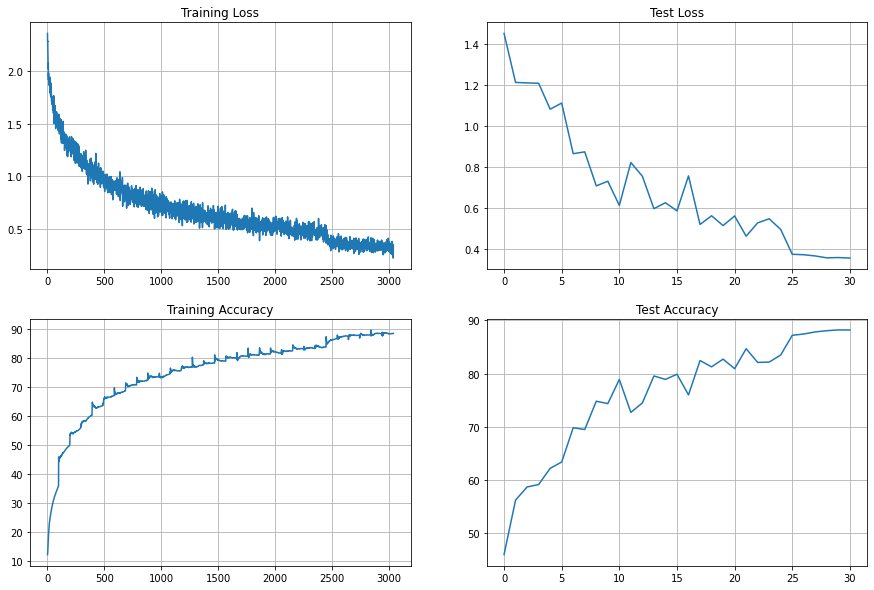

In [29]:
modelTrainTestHistory (train_losses, train_acc, test_losses, test_acc)

In [0]:
#import torch
#torch.save(model, './gdrive/My Drive/EVA_Library/for_testing_gradCam.pth')

In [0]:
#import torch
#torch.load('./gdrive/My Drive/EVA_Library/for_testing_gradCam.pth')

# Displaying the mis-classified images

In [23]:
ground_truth, classified_lie, my_misclassified_images = misClassfied(model=model, 
                                                                device=device, 
                                                                test_loader=test_loader, 
                                                                req_num_images=25)

ground_truth = ground_truth.numpy().squeeze().astype(int)
classified_lie = classified_lie.numpy().squeeze().astype(int)

# Not showing the mis-classified image here as it will be shown in GradCam
# Bug:<To-do>: displayMisClassfiedImages function de-normalizes the image; if the 'my_misclassified_images' sent as is to
# to the gradCam then images will fade
# displayMisClassfiedImages (ground_truth, Args.dataset_mean, Args.dataset_std, classified_lie, my_misclassified_images)

./gdrive/My Drive/EVA_Library/cnnModels/CNNModel.py:183: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


In [24]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']

grad_cam = GradCAMView(
    model, layers,
    device, Args.dataset_mean, Args.dataset_std,
)

gradcam_views = grad_cam(my_misclassified_images)

Mode set to GradCAM.


./gdrive/My Drive/EVA_Library/cnnModels/CNNModel.py:183: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


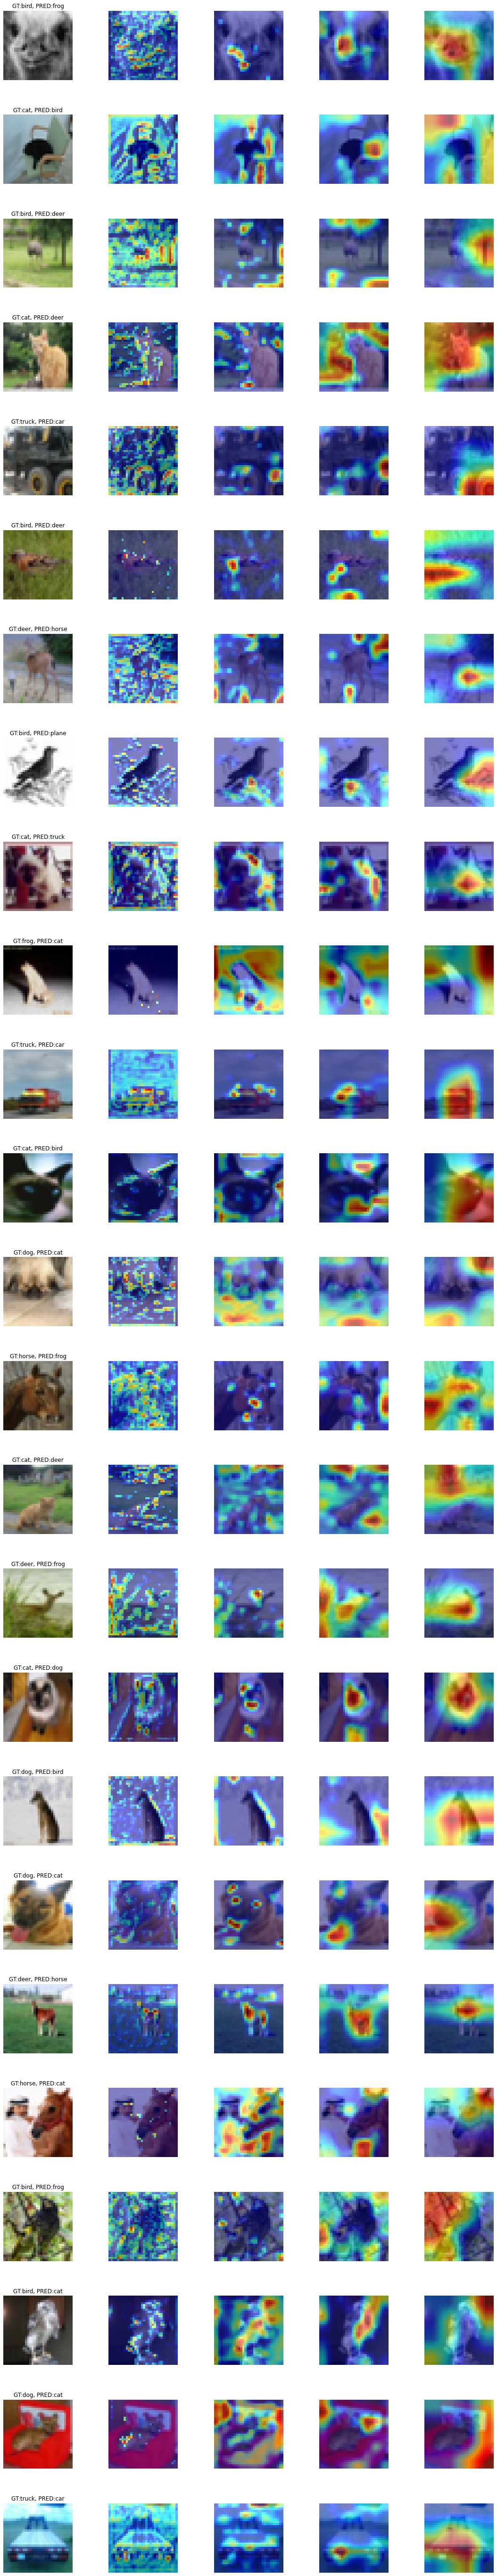

<Figure size 432x288 with 0 Axes>

In [25]:
plot_gradcam(gradcam_views, layers, ground_truth, classified_lie, 'grad_cam')